# deltaT selection example - PICO

Note that melt rates were calculated using PISM-PICO. If you would like to have the underlying data, please get in touch with Ronja Reese

In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from parameter_selection_toolbox import *

# Settings

In [2]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/"
ensemble_path="/media/NAS2/pism_out/"

# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]


# parameterisation ensemble table 
p1_name = 'ocean.pico.overturning_coefficent'
p2_name = 'ocean.pico.heat_exchange_coefficent'

pism_present_day_ensemble = "pism_11_ismip7_picotest_zhou_initmip8km"
ensemble_table = pd.read_csv('./'+pism_present_day_ensemble+'.txt',
                                 sep=r'\s+',index_col=0)
#ensemble_table

# Supporting data

In [3]:
# basin file to aggregate and compare data, note that this has been pre-processed for pism input, please see https://github.com/pism/pism-ais.git or ask me
pico_climatology = xr.load_dataset(os.path.join(data_path,"climatologies_on_ismip_grid","zhou_annual_30_sep","zhou_ismip8km_readyForPISM_means.nc"))
baseline_temp_per_basin = pico_climatology['theta_ocean'].groupby(pico_climatology['basins']).mean()

number_of_basins = int(pico_climatology['basins'].max().values)

# load pico boxes, for applying constraints on pico parameters and masking melt in ice shelves
boxes = xr.load_dataset(os.path.join(ensemble_path,"pism_11_ismip7_picotest_zhou_initmip8km_"+ensemble_table.index[0],"extras.nc"),
                        decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                               'pico_basal_melt_rate', 'pico_contshelf_mask',
                                                               'pico_ice_rise_mask', 'pico_overturning',
                                                               'pico_salinity', 'pico_salinity_box0',
                                                               'pico_shelf_mask', 'pico_temperature', 
                                                               'pico_temperature_box0'] )['pico_box_mask'].isel(time=0)

In [4]:
#PaoloDataImbie = pd.read_csv('../Melt_Paolo_Err_Adusumilli_imbie2.csv', index_col=0)
PaoloDataPICO = pd.read_csv('PaoloData_pico.csv', index_col=0)

# Find optimal deltaT for PICO
Note that this uses the PICO basins, which differ from the imbie2 basins as used in ismip7

In [5]:

model_runs = [] 
p1s = []
p2s = []

for i,ehash in enumerate(ensemble_table.index):
    
    p1 = ensemble_table.loc[ehash, p1_name]
    p2 = ensemble_table.loc[ehash, p2_name]
    p1s.append(p1)
    p2s.append(p2) 
    #print(i, 'p1=', p1, ' p2=', p2)

    output_path = os.path.join(ensemble_path, pism_present_day_ensemble+"_"+ehash)

    try:
        #print('Loading dataset')
        result_ds = xr.load_dataset(output_path+"/optimised.nc")
    except:
        ds = xr.open_dataset(os.path.join(output_path,'extras.nc'),decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                                                                    'pico_box_mask', 'pico_contshelf_mask',
                                                                                                   'pico_ice_rise_mask', 'pico_overturning',
                                                                                                   'pico_salinity', 'pico_salinity_box0',
                                                                                                   'pico_shelf_mask', 'pico_temperature', 
                                                                                                  ],)
        ds = ds.rename({'pico_basal_melt_rate':'melt_rate'})
        # convert time to deltaT, this is a trick to avoid running an ensemble over deltaT
        deltaT_coords = np.round(ds['pico_temperature_box0'].groupby(pico_climatology['basins']).mean().sel(basins=14) - 273.15 - baseline_temp_per_basin.sel(basins=14), 2)
        new_ds = xr.Dataset( data_vars=dict(melt_rate=(["deltaT","y", "x"], ds["melt_rate"].where(boxes>0,np.nan).values)), 
                                 coords=dict(x=(["x"], ds['x'].values), y=(["y"], ds['y'].values), deltaT=(["deltaT"],deltaT_coords.values) ))
        ds.close()
    
        
        outname = os.path.join(ensemble_path,pism_present_day_ensemble+'_'+ehash, "optimised.nc")
        result_ds = select_optimal_deltaT(new_ds, pico_climatology['basins'], boxes ,PaoloDataPICO, 'pico', outname, reso, ice_density)

    result_ds = result_ds.assign_coords(ehash=ehash)
    model_runs.append(result_ds)

In [6]:
print('Combining datasets')
pd_ensemble_sel = xr.concat(model_runs, dim='ehash', coords='minimal')

# change ehash to C and gammaT dimensions
pd_ensemble_sel = pd_ensemble_sel.assign_coords({ 
    'p1': ('ehash', p1s),
    'p2': ('ehash', p2s)
}).set_index(ehash=['p1', 'p2']).unstack('ehash')


pd_ensemble_sel.encoding = {}
pd_ensemble_sel.to_netcdf('Ensemble_pd_optimaldeltaT.nc')

Combining datasets


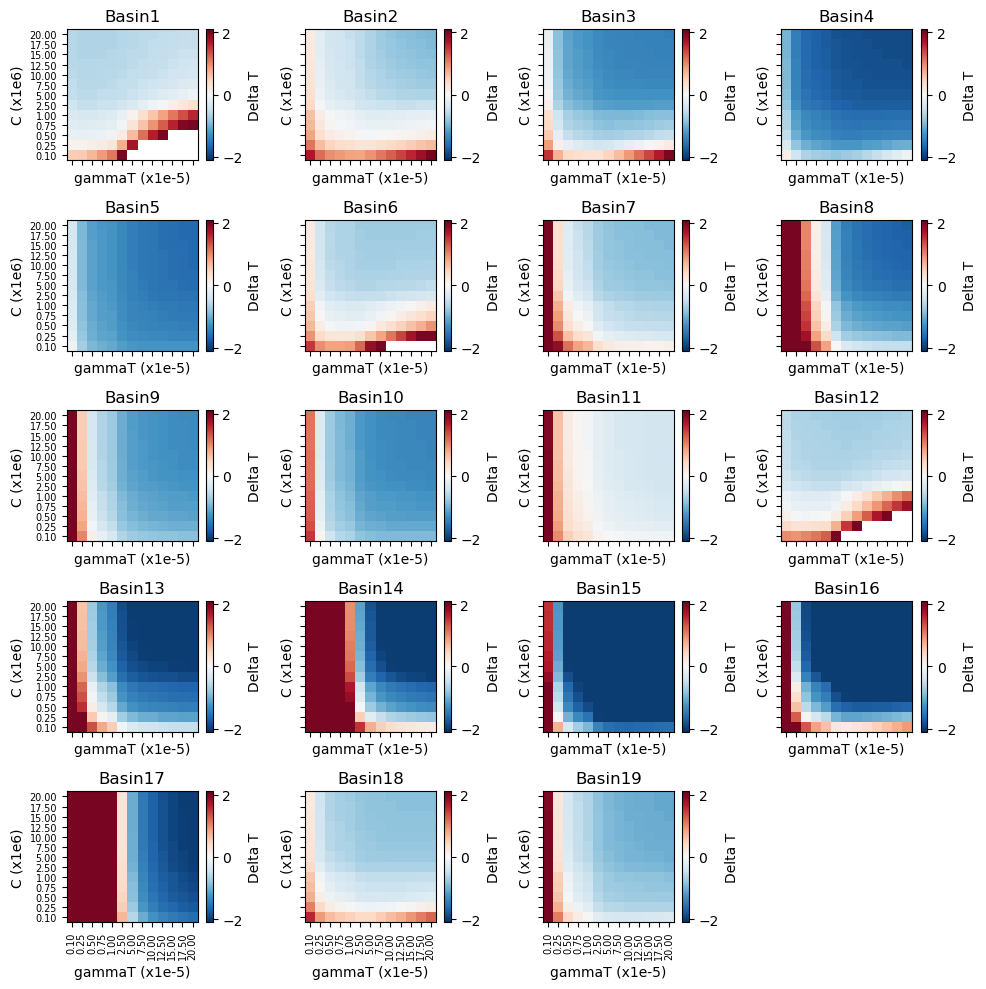

In [7]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.imshow(pd_ensemble_sel['optimal_deltaT_per_basin'].sel(basin=i+1).values,cmap='RdBu_r', vmin=-2.1, vmax=2.1, origin='lower')
    plt.colorbar(im, label='Delta T')
    p1_values = pd_ensemble_sel['p1'].values/1e6
    p2_values = pd_ensemble_sel['p2'].values*1e5
    
    ax.set_yticks(np.arange(len(p1_values)))
    ax.set_yticklabels([f'{v:.2f}' for v in p1_values], fontsize=7)#, rotation=45)
    
    ax.set_xticks(np.arange(len(p2_values)))
    ax.set_xticklabels([f'{v:.2f}' for v in p2_values], rotation=90, fontsize=7)

    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('gammaT (x1e-5)')
    ax.set_ylabel('C (x1e6)')
    
fig.tight_layout()
axes.flat[-1].set_visible(False)
#plt.savefig(os.path.join(figure_dir,'PICO_Ensemble_optimalDeltaT_deltaTPerBasin.png'))

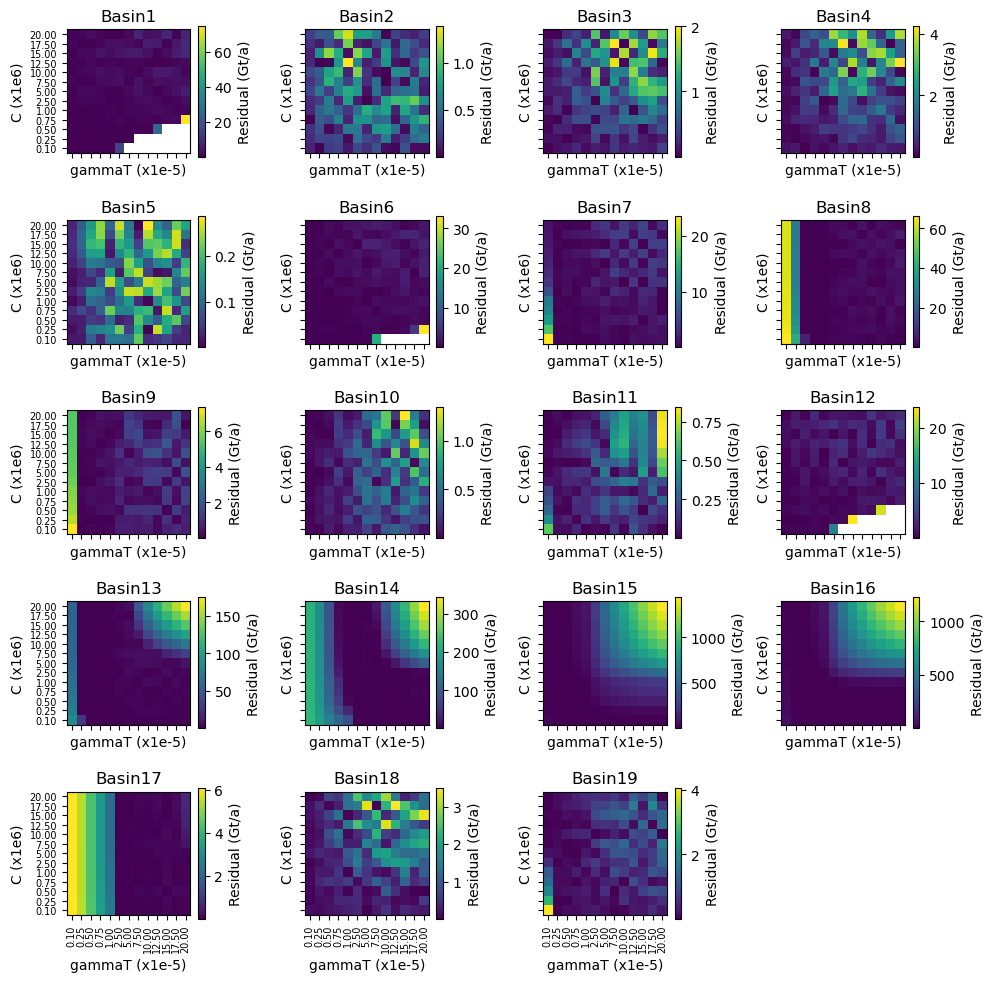

In [8]:
# Plot residuals for each PICO basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10, 10))


for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.imshow(pd_ensemble_sel['residual_per_basin'].sel(basin=i+1).values, origin='lower')
    plt.colorbar(im, label='Residual (Gt/a)')
    p1_values = pd_ensemble_sel['p1'].values/1e6
    p2_values = pd_ensemble_sel['p2'].values*1e5
    
    ax.set_yticks(np.arange(len(p1_values)))
    ax.set_yticklabels([f'{v:.2f}' for v in p1_values], fontsize=7)#, rotation=45)
    
    ax.set_xticks(np.arange(len(p2_values)))
    ax.set_xticklabels([f'{v:.2f}' for v in p2_values], rotation=90, fontsize=7)

    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('gammaT (x1e-5)')
    ax.set_ylabel('C (x1e6)')
    

fig.tight_layout()
axes.flat[-1].set_visible(False)
#plt.savefig(os.path.join(figure_dir,'PICO_Ensemble_optimalDeltaT_ResidualsPerBasin.png'))

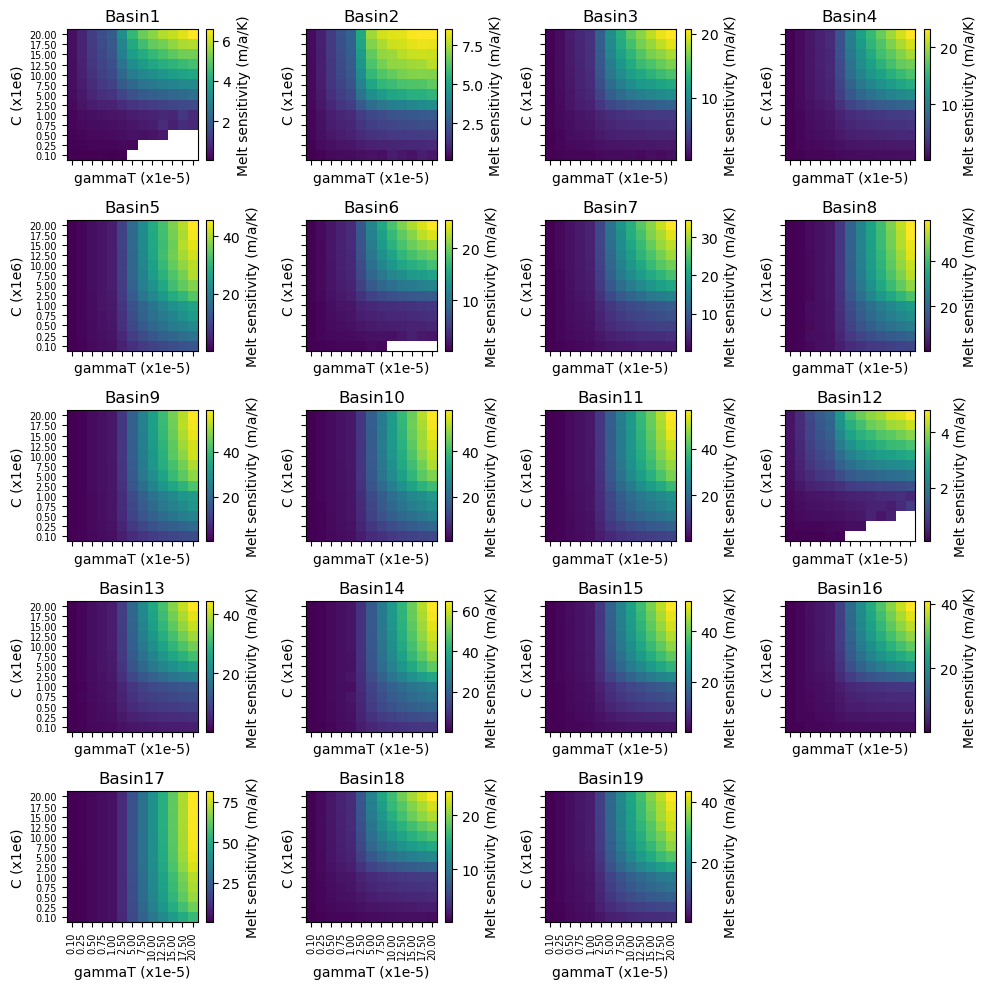

In [9]:
# Plot rough sensitivity estimates (note that they are not calculated over equal intervals)

fig,axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.imshow(pd_ensemble_sel['sensitivity_per_basin'].sel(basin=i+1).values, origin='lower')
    plt.colorbar(im, label='Melt sensitivity (m/a/K)')
    p1_values = pd_ensemble_sel['p1'].values/1e6
    p2_values = pd_ensemble_sel['p2'].values*1e5
    
    ax.set_yticks(np.arange(len(p1_values)))
    ax.set_yticklabels([f'{v:.2f}' for v in p1_values], fontsize=7)#, rotation=45)
    
    ax.set_xticks(np.arange(len(p2_values)))
    ax.set_xticklabels([f'{v:.2f}' for v in p2_values], rotation=90, fontsize=7)

    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('gammaT (x1e-5)')
    ax.set_ylabel('C (x1e6)')
    
fig.tight_layout()
axes.flat[-1].set_visible(False)
#plt.savefig(os.path.join(figure_dir,'PICO_Ensemble_optimalDeltaT_RoughSensitivityEstimatesPerBasin.png'))

# Apply optimal deltaT to ocean modelling datasets

In [10]:
# if you want to skip the calculation of pd_ensemble_sel
pd_ensemble_sel = xr.load_dataset('Ensemble_pd_optimaldeltaT.nc', drop_variables=['timestamp'])

In [11]:
# iterate over all subensembles

opt_ensemble = xr.load_dataset('Ensemble_pd_optimaldeltaT.nc')
basins = pico_climatology['basins']

ensembles = ['pism_11_ismip7_picotest_Mathiot_cold_initmip8km', 'pism_11_ismip7_picotest_Mathiot_warm_initmip8km']


# get deltaT's relative to present-day climatology
model_file = os.path.join("/media/NAS2/pism_out/",pism_present_day_ensemble+"_"+'ee8f65fd')
ds = xr.open_dataset(model_file+'/extras.nc',decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                                                                    'pico_box_mask', 'pico_contshelf_mask',
                                                                                                   'pico_ice_rise_mask', 'pico_overturning',
                                                                                                   'pico_salinity', 'pico_salinity_box0',
                                                                                                   'pico_shelf_mask', 'pico_temperature', 
                                                                                                  ],
                                    )
deltaT_coords = np.round(ds['pico_temperature_box0'].groupby(pico_climatology['basins']).mean().sel(basins=14) - 273.15 - baseline_temp_per_basin.sel(basins=14), 2)
ds.close()

for ensemble in ensembles:
    print(ensemble)
    for i,ehash in enumerate(ensemble_table.index):
        p1 = ensemble_table.loc[ehash, p1_name]
        p2 = ensemble_table.loc[ehash, p2_name]
        #print(ehash, i, 'p1=', p1, ' p2=', p2)

        # pre-process time to deltaT dimension
        pico_output_file = os.path.join(ensemble_path, ensemble+"_"+ehash)
        ds = xr.open_dataset(pico_output_file+'/extras.nc',decode_timedelta=True, drop_variables=['pico_T_star', 'shelfbtemp', 
                                                                                                    'pico_box_mask', 'pico_contshelf_mask',
                                                                                                   'pico_ice_rise_mask', 'pico_overturning',
                                                                                                   'pico_salinity', 'pico_salinity_box0',
                                                                                                   'pico_shelf_mask', 'pico_temperature', 
                                                                                                  ], )
        ds = ds.rename({'pico_basal_melt_rate':'melt_rate'})
        new_ds = xr.Dataset( data_vars=dict(melt_rate=(["deltaT","y", "x"], ds["melt_rate"].where(boxes>0,np.nan).values)), coords=dict( 
                                 x=(["x"], ds['x'].values), y=(["y"], ds['y'].values), deltaT=(["deltaT"],deltaT_coords.values) ))
        ds.close()
    
        
        outname = os.path.join(ensemble_path,ensemble+"_"+ehash,"optimised.nc")
        
        select_subensemble_using_optimal_deltaT(new_ds, basins, opt_ensemble, outname, p1, p2)
        new_ds.close()
      

pism_11_ismip7_picotest_Mathiot_cold_initmip8km
pism_11_ismip7_picotest_Mathiot_warm_initmip8km


# Combine datasets

In [12]:
pism_present_day_ensemble = "pism_11_ismip7_picotest_zhou_initmip8km"
pism_mathiot_cold_ensemble = "pism_11_ismip7_picotest_Mathiot_cold_initmip8km"
pism_mathiot_warm_ensemble = "pism_11_ismip7_picotest_Mathiot_warm_initmip8km"


In [13]:
# Create ensemble
pd_ensemble = load_melt_rates_into_dataset(pism_present_day_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save pd_ensemble
pd_ensemble.encoding = {}
pd_ensemble.to_netcdf('Ensemble_'+pism_present_day_ensemble+'_optimaldeltaT.nc')

Loading pism_11_ismip7_picotest_zhou_initmip8km into one dataset...
Combining datasets


In [14]:
mathiot_cold_ensemble = load_melt_rates_into_dataset(pism_mathiot_cold_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_cold_ensemble.encoding = {}
mathiot_cold_ensemble.to_netcdf('Ensemble_'+pism_mathiot_cold_ensemble+'_optimaldeltaT.nc')

Loading pism_11_ismip7_picotest_Mathiot_cold_initmip8km into one dataset...
Combining datasets


In [15]:
mathiot_warm_ensemble = load_melt_rates_into_dataset(pism_mathiot_warm_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_warm_ensemble.encoding = {}
mathiot_warm_ensemble.to_netcdf('Ensemble_'+pism_mathiot_warm_ensemble+'_optimaldeltaT.nc')

Loading pism_11_ismip7_picotest_Mathiot_warm_initmip8km into one dataset...
Combining datasets
